In [15]:
!pip install --upgrade numpy gensim


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.5-cp312-cp312-win_amd64.whl.metadata (60 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
!pip install pandas matplotlib seaborn scikit-learn nltk

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import string
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score





# **Data PreProcessing: Exploring the Data**

In [18]:
# Load the dataset
df = pd.read_csv('Combined .csv')

# Display the first few rows
print(df.head())

print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns)

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())
# Check class distribution
print(df['Label'].value_counts())


  Sr. No.                                         News Items Label
0       1  ٹی ٹی پی نے پنجاب حکومت کے ہیلی کاپٹر کے عملے ...  FAKE
1       2          مارک زکربرگ سیاست میں آنے کا سوچ رہے ہیں۔  FAKE
2       3     فریدہ جلال نے اپنی موت کی افواہوں پر تنقید کی۔  FAKE
3       4  جعلی خبریں: پاپ اسٹار حدیقہ کیانی نے جعلی منشی...  FAKE
4       5  صنم ماروی نے میڈیا پر گردش کرنے والی زیادتی او...  FAKE
Shape of dataset: (10106, 3)

Columns:
 Index(['Sr. No.', 'News Items', 'Label'], dtype='object')

Missing values:
 Sr. No.       22
News Items    22
Label         22
dtype: int64
Label
FAKE     5039
TRUE     4997
TRUE       33
FAKE       14
Label       1
Name: count, dtype: int64


In [19]:
# Drop rows with missing values
df = df.dropna()
print("Shape after dropping missing values:", df.shape)


Shape after dropping missing values: (10084, 3)


In [20]:
# Drop Sr. No. column
if 'Sr. No.' in df.columns:
    df.drop(columns=['Sr. No.'], inplace=True)

In [21]:
# Clean Label values,Strip whitespace and remove invalid labels
df['Label'] = df['Label'].str.strip().str.upper()


# Keep only rows with correct labels
df = df[df['Label'].isin(['FAKE', 'TRUE'])]

# Final stats
print("Shape after cleaning:", df.shape)
print("\nLabel distribution:\n", df['Label'].value_counts())

Shape after cleaning: (10083, 2)

Label distribution:
 Label
FAKE    5053
TRUE    5030
Name: count, dtype: int64


In [22]:
print(df.iloc[5052])


News Items    COVID-19 سے صحت یاب ہونے کے بعد جشن منانے کے د...
Label                                                      FAKE
Name: 5052, dtype: object


In [23]:
# Full row duplicates
full_duplicates = df[df.duplicated()]
print("Full duplicate rows:\n", full_duplicates)
print("\nNumber of full duplicate rows:", full_duplicates.shape[0])
# Duplicates based on News Items and Label only
partial_duplicates = df[df.duplicated(subset=["News Items", "Label"])]
print("\nDuplicate rows based on News Items and Label:\n", partial_duplicates)
print("\nNumber of partial duplicates (News Items + Label):", partial_duplicates.shape[0])
df_cleaned = df.drop_duplicates()
df_cleaned = df.drop_duplicates(subset=["News Items", "Label"])
'''
Since this is a text classification dataset for fake vs true news:

Duplicates (especially same news with same label) might bias the model.

So, it's safer to drop duplicates based on 'News Items' and 'Label' to make the dataset more diverse and less repetitive.


'''


df_cleaned = df.drop_duplicates(subset=["News Items", "Label"]).reset_index(drop=True)
print("Cleaned dataset shape:", df_cleaned.shape)


Full duplicate rows:
                                               News Items Label
1484   کیرالہ میں ایم ایل اے کی گاڑی پر پاکستان کا جھنڈا  FAKE
1513   پاکستان کرکٹ بورڈ کے نئے چیئرمین کا انتخاب خبر...  FAKE
1514   10 جنوری 2021 کی رات کو پورا پاکستان تاریکی می...  FAKE
1516   پاکستانی کرکٹ ٹیم کے ہیڈ کوچ مصباح الحق کی موت...  FAKE
1517   پاکستان میں انٹرنیشنل کرکٹ کی واپسی کے امکانات...  FAKE
...                                                  ...   ...
9846   اے پی کی رپورٹنگ کے مطابق، پاکستان میں مذہبی ا...  TRUE
9847   پاکستان کے شمالی شہر سیالکوٹ میں فٹ بال کی کم ...  TRUE
9848   بلیک کیپس اور پاکستان کے درمیان پہلے ٹیسٹ کے چ...  TRUE
9849   حالیہ دہائیوں میں، آسیان اکنامک کمیونٹی (AEC)،...  TRUE
10082  بھارت کے نوجوان معروف سوشل میڈیا اسٹار اور کام...  TRUE

[848 rows x 2 columns]

Number of full duplicate rows: 848

Duplicate rows based on News Items and Label:
                                               News Items Label
1484   کیرالہ میں ایم ایل اے کی گاڑی پر پاکستان کا 

In [24]:
# Final stats
print("Shape after cleaning:", df_cleaned.shape)
print("Label distribution:\n", df_cleaned['Label'].value_counts())
print(df_cleaned['Label'].unique())


Shape after cleaning: (9235, 2)
Label distribution:
 Label
FAKE    4637
TRUE    4598
Name: count, dtype: int64
['FAKE' 'TRUE']


#Visualization

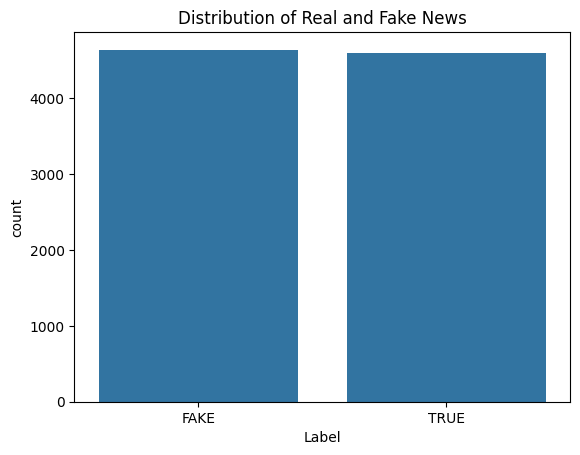

In [25]:
# Plot class distribution
sns.countplot(x='Label', data=df_cleaned)
plt.title('Distribution of Real and Fake News')
plt.show()


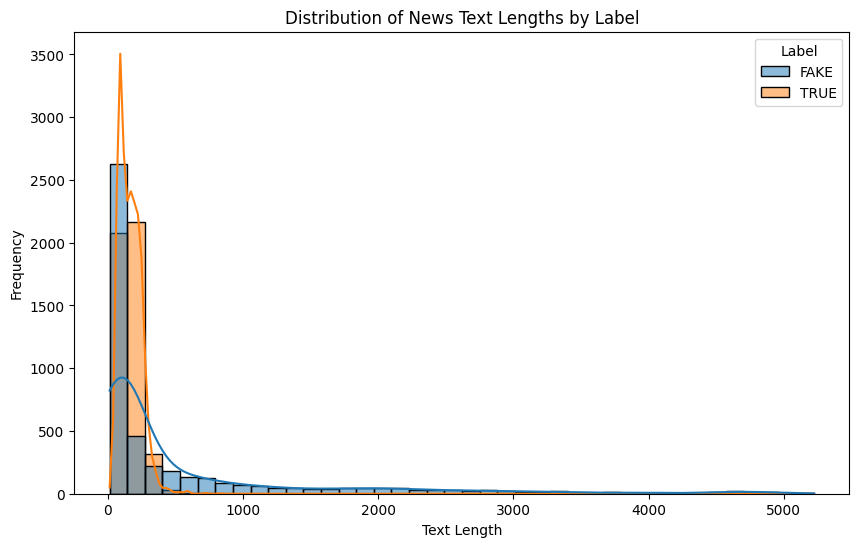

In [26]:
'''
Both types have a sharp peak at shorter lengths:

Most news articles (FAKE and TRUE) are relatively short (likely under 500 words).

There's a sharp drop in frequency as text length increases.

FAKE news appears slightly more spread out:

The FAKE label has more longer articles (higher tail on the right).

This suggests fake news might include more verbose or exaggerated text.

TRUE news is more tightly clustered:

It’s concentrated more closely around a narrow range.

This implies real news tends to be more concise and consistent in length.

'''


df_cleaned['Text Length'] = df_cleaned['News Items'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='Text Length', hue='Label', kde=True, bins=40)
plt.title('Distribution of News Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [27]:
!apt-get -y install fonts-noto


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


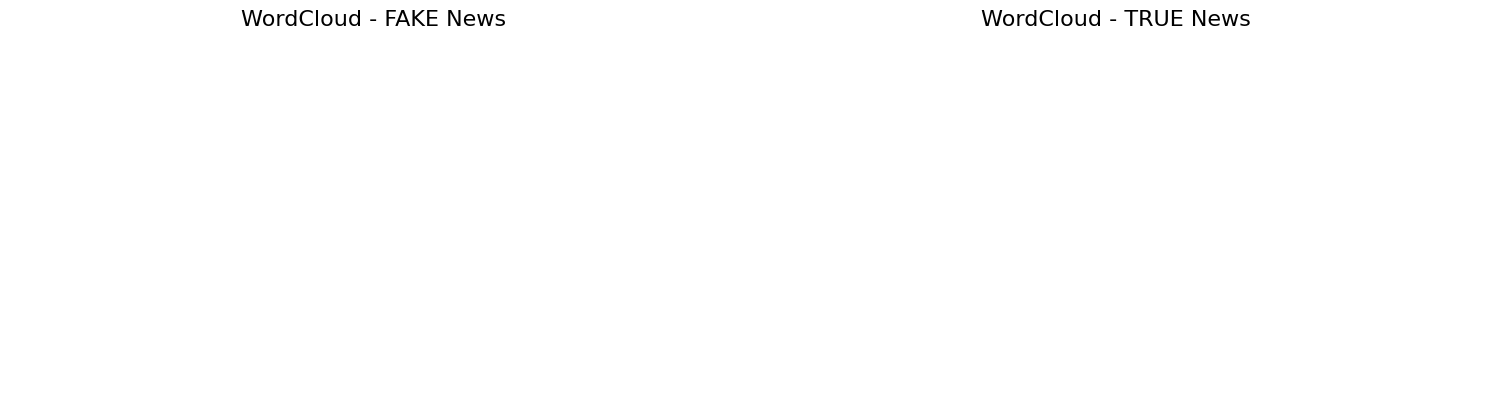

In [28]:
import os

urdu_fonts = []
for root, dirs, files in os.walk("/usr/share/fonts/"):
    for file in files:
        if 'NotoNastaliq' in file or 'Urdu' in file:
            urdu_fonts.append(os.path.join(root, file))

urdu_fonts  # print font paths
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine texts
fake_text = ' '.join(df_cleaned[df_cleaned['Label'] == 'FAKE']['News Items'])
true_text = ' '.join(df_cleaned[df_cleaned['Label'] == 'TRUE']['News Items'])

# Use Urdu font
font_path = 'NotoNastaliqUrdu-Regular.ttf'

wordcloud_fake = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate(fake_text)
wordcloud_true = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate(true_text)

# Plotting
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('WordCloud - FAKE News', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('WordCloud - TRUE News', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
df_cleaned

,News Items,Label,Text Length
0,ٹی ٹی پی نے پنجاب حکومت کے ہیلی کاپٹر کے عملے ...,FAKE,77
1,مارک زکربرگ سیاست میں آنے کا سوچ رہے ہیں۔,FAKE,41
2,فریدہ جلال نے اپنی موت کی افواہوں پر تنقید کی۔,FAKE,46
3,جعلی خبریں: پاپ اسٹار حدیقہ کیانی نے جعلی منشی...,FAKE,90
4,صنم ماروی نے میڈیا پر گردش کرنے والی زیادتی او...,FAKE,85
...,...,...,...
9230,شاہین باغ، بریانی، گولیاں، پاکستان - یوگی آدتی...,TRUE,82
9231,بے روزگاری الاؤنس، کیش بیک اسکیمیں - کانگریس ن...,TRUE,81
9232,چدمبرم نے بجٹ پر تنقید کی، حکومت کا کہنا ہے کہ...,TRUE,83
9233,"نتیش نے بہار میں 16,443 کلومیٹر طویل انسانی زن...",TRUE,98


# **Text Preprocessing**

**Label Encoding**

In [30]:
# Encode categorical columns (e.g., Label column)
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode 'Label' column (Fake and True)
df_cleaned['Label'] = label_encoder.fit_transform(df_cleaned['Label'])  # FAKE=0, TRUE=1
df_cleaned

,News Items,Label,Text Length
0,ٹی ٹی پی نے پنجاب حکومت کے ہیلی کاپٹر کے عملے ...,0,77
1,مارک زکربرگ سیاست میں آنے کا سوچ رہے ہیں۔,0,41
2,فریدہ جلال نے اپنی موت کی افواہوں پر تنقید کی۔,0,46
3,جعلی خبریں: پاپ اسٹار حدیقہ کیانی نے جعلی منشی...,0,90
4,صنم ماروی نے میڈیا پر گردش کرنے والی زیادتی او...,0,85
...,...,...,...
9230,شاہین باغ، بریانی، گولیاں، پاکستان - یوگی آدتی...,1,82
9231,بے روزگاری الاؤنس، کیش بیک اسکیمیں - کانگریس ن...,1,81
9232,چدمبرم نے بجٹ پر تنقید کی، حکومت کا کہنا ہے کہ...,1,83
9233,"نتیش نے بہار میں 16,443 کلومیٹر طویل انسانی زن...",1,98


**Removing Stop Words**

In [31]:
import pandas as pd
import string


In [32]:
with open('stopwords-ur.txt', 'r', encoding='utf-8') as f:  #loading stopwords
    urdu_stopwords = set(f.read().splitlines())


In [33]:
def clean_urdu_text(text):
    return re.sub(r'[^\u0600-\u06FF\s]', '', text)

def preprocess_text(text):
    text = text.lower()
    text = clean_urdu_text(text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in urdu_stopwords]
    return ' '.join(tokens)


In [34]:
df_cleaned['clean_text'] = df_cleaned['News Items'].apply(preprocess_text)


In [35]:
print(df_cleaned[df_cleaned['Label'] == 0]['clean_text'].head())


0    ٹی ٹی پی نے پنجاب حکومت ہیلی کاپٹر عملے کو یرغ...
1                مارک زکربرگ سیاست میں آنے کا سوچ ہیں۔
2             فریدہ جلال نے اپنی موت افواہوں تنقید کی۔
3    جعلی خبریں پاپ اسٹار حدیقہ کیانی نے جعلی منشیا...
4    صنم ماروی نے میڈیا گردش کرنے والی زیادتی ڈکیتی...
Name: clean_text, dtype: object


In [36]:
df_cleaned

,News Items,Label,Text Length,clean_text
0,ٹی ٹی پی نے پنجاب حکومت کے ہیلی کاپٹر کے عملے ...,0,77,ٹی ٹی پی نے پنجاب حکومت ہیلی کاپٹر عملے کو یرغ...
1,مارک زکربرگ سیاست میں آنے کا سوچ رہے ہیں۔,0,41,مارک زکربرگ سیاست میں آنے کا سوچ ہیں۔
2,فریدہ جلال نے اپنی موت کی افواہوں پر تنقید کی۔,0,46,فریدہ جلال نے اپنی موت افواہوں تنقید کی۔
3,جعلی خبریں: پاپ اسٹار حدیقہ کیانی نے جعلی منشی...,0,90,جعلی خبریں پاپ اسٹار حدیقہ کیانی نے جعلی منشیا...
4,صنم ماروی نے میڈیا پر گردش کرنے والی زیادتی او...,0,85,صنم ماروی نے میڈیا گردش کرنے والی زیادتی ڈکیتی...
...,...,...,...,...
9230,شاہین باغ، بریانی، گولیاں، پاکستان - یوگی آدتی...,1,82,شاہین باغ، بریانی، گولیاں، پاکستان یوگی آدتیہ ...
9231,بے روزگاری الاؤنس، کیش بیک اسکیمیں - کانگریس ن...,1,81,بے روزگاری الاؤنس، کیش بیک اسکیمیں کانگریس نے ...
9232,چدمبرم نے بجٹ پر تنقید کی، حکومت کا کہنا ہے کہ...,1,83,چدمبرم نے بجٹ تنقید کی، حکومت کا کہنا سنگین می...
9233,"نتیش نے بہار میں 16,443 کلومیٹر طویل انسانی زن...",1,98,نتیش نے بہار میں کلومیٹر طویل انسانی زنجیر قیا...


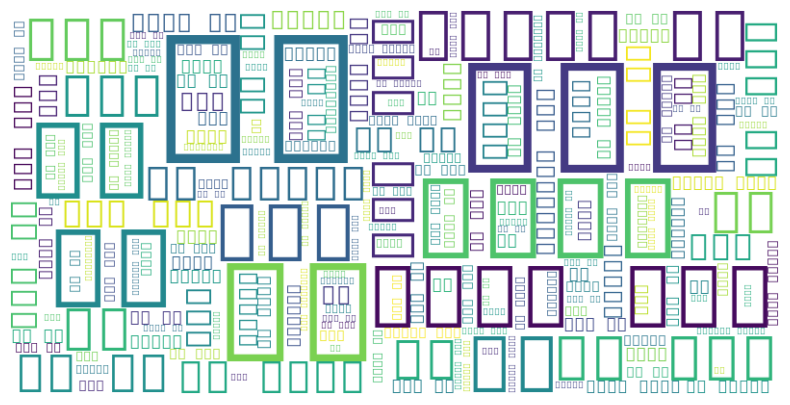

In [37]:
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=200).generate(' '.join(df_cleaned['clean_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
# Check the length of the cleaned text
df_cleaned['clean_text'].apply(len).describe()


count    9235.000000
mean      288.935030
std       560.868046
min         0.000000
25%        70.000000
50%       115.000000
75%       192.000000
max      4214.000000
Name: clean_text, dtype: float64

**TF-IDF**

In [39]:
#TF-IDF to convert text data into numerical features:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['clean_text'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_cleaned = pd.concat([df_cleaned, X_tfidf_df], axis=1)
y=df_cleaned['Label']




**WORD2VEC**

In [40]:
!pip install gensim


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
from gensim.models import Word2Vec

df_cleaned['tokens'] = df_cleaned['clean_text'].apply(lambda x: x.split())

#train Word2Vec model on corpus
w2v_model=Word2Vec(sentences=df_cleaned['tokens'], vector_size=100, window=5, min_count=1, workers=4)

#func to convert sentence to average word vectors
def get_average_vector(tokens, model, vector_size):
    valid_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(vector_size)

#feature matrix
X_w2v = np.array([get_average_vector(tokens, w2v_model, 100) for tokens in df_cleaned['tokens']])
y = df_cleaned['Label']

In [42]:
print((X_w2v[0]))

[-0.02176615  0.44651991 -0.34893018 -0.23679556  0.1451961  -0.80498552
  0.19099025  0.53535765 -0.28596488 -0.61738902 -0.25974762 -0.5609321
  0.04930551 -0.10994989  0.19632633 -0.24240923  0.43660304 -0.70343024
 -0.86846763 -1.19644737  0.41517636  0.32101065  0.01796267  0.20587155
 -0.03462071  0.47464949 -0.31787539 -0.2010103  -0.49363428  0.66606385
  0.11570422 -0.0535216  -0.09663552 -0.69134384 -0.16134427  0.69910038
  0.17774591  0.13491011 -0.29149246 -0.57415289 -0.07340549 -0.7703113
  0.07755431  0.2572532   0.39262772  0.24461924 -0.26953945 -0.10204262
 -0.27914014  0.20084248 -0.21141453 -0.29998326 -0.68861383 -0.28578568
  0.1796197  -0.17634162  0.39091167  0.36413345 -0.35498872  0.23747087
 -0.09444393 -0.15397581 -0.01576777  0.02301097 -0.47627598  1.05423236
  0.14937404  0.5456267  -0.23470581  0.59706134 -0.08030333  0.15282226
  0.62040752 -0.00334369 -0.21572898  0.19297723 -0.25739092  0.38298851
  0.0683972  -0.28076831 -0.62296325  0.44913888 -0.2

**BERT**

In [43]:
!pip install transformers
!pip install torch

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")

#tokenize and encode in batches
def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[0][0]  #CLS token
        embeddings.append(cls_embedding.numpy())
    return np.array(embeddings)

#embeddings
X_bert=get_bert_embeddings(df_cleaned['clean_text'])

100%|██████████| 9235/9235 [06:14<00:00, 24.65it/s]


WE WILL BE USING BERT, TF-IDF AND WORD2VEC FOR TRAINING AND SEE WHICH GIVES BEST ACCURACY

# **Feature Selection & Engineering**


Slightly imbalanced data
- FAKE: 4637
- TRUE: 4598

Lets look at different ways to deal with this.


**Re Sampling**

In [45]:
'''
1-One way to oversample the minority class is using SMOTE (Synthetic Minority Over-sampling Technique),
which generates synthetic data points for the minority class.
'''
smote = SMOTE(random_state=42)
X_resampled_tf, y_resampled = smote.fit_resample(X_tfidf_df, y)
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Class distribution after SMOTE:
Label
0    4637
1    4637
Name: count, dtype: int64


In [46]:

smote = SMOTE(random_state=42)
X_resampled_w2v, y_resampled = smote.fit_resample(X_w2v, y)
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
Label
0    4637
1    4637
Name: count, dtype: int64


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [47]:

smote = SMOTE(random_state=42)
X_resampled_bert, y_resampled = smote.fit_resample(X_bert, y)
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Class distribution after SMOTE:
Label
0    4637
1    4637
Name: count, dtype: int64


In [48]:
df_cleaned#it has tf idf

,News Items,Label,Text Length,clean_text,آباد,آخری,آر,آغاز,آف,آنے,...,ہیں,ہے,یا,یاد,یقین,یقینی,یو,یونیورسٹی,یہاں,tokens
0,ٹی ٹی پی نے پنجاب حکومت کے ہیلی کاپٹر کے عملے ...,0,77,ٹی ٹی پی نے پنجاب حکومت ہیلی کاپٹر عملے کو یرغ...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.16828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[ٹی, ٹی, پی, نے, پنجاب, حکومت, ہیلی, کاپٹر, عم..."
1,مارک زکربرگ سیاست میں آنے کا سوچ رہے ہیں۔,0,41,مارک زکربرگ سیاست میں آنے کا سوچ ہیں۔,0.0,0.0,0.0,0.0,0.0,0.58234,...,0.350694,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[مارک, زکربرگ, سیاست, میں, آنے, کا, سوچ, ہیں۔]"
2,فریدہ جلال نے اپنی موت کی افواہوں پر تنقید کی۔,0,46,فریدہ جلال نے اپنی موت افواہوں تنقید کی۔,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[فریدہ, جلال, نے, اپنی, موت, افواہوں, تنقید, کی۔]"
3,جعلی خبریں: پاپ اسٹار حدیقہ کیانی نے جعلی منشی...,0,90,جعلی خبریں پاپ اسٹار حدیقہ کیانی نے جعلی منشیا...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[جعلی, خبریں, پاپ, اسٹار, حدیقہ, کیانی, نے, جع..."
4,صنم ماروی نے میڈیا پر گردش کرنے والی زیادتی او...,0,85,صنم ماروی نے میڈیا گردش کرنے والی زیادتی ڈکیتی...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[صنم, ماروی, نے, میڈیا, گردش, کرنے, والی, زیاد..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9230,شاہین باغ، بریانی، گولیاں، پاکستان - یوگی آدتی...,1,82,شاہین باغ، بریانی، گولیاں، پاکستان یوگی آدتیہ ...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[شاہین, باغ،, بریانی،, گولیاں،, پاکستان, یوگی,..."
9231,بے روزگاری الاؤنس، کیش بیک اسکیمیں - کانگریس ن...,1,81,بے روزگاری الاؤنس، کیش بیک اسکیمیں کانگریس نے ...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[بے, روزگاری, الاؤنس،, کیش, بیک, اسکیمیں, کانگ..."
9232,چدمبرم نے بجٹ پر تنقید کی، حکومت کا کہنا ہے کہ...,1,83,چدمبرم نے بجٹ تنقید کی، حکومت کا کہنا سنگین می...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[چدمبرم, نے, بجٹ, تنقید, کی،, حکومت, کا, کہنا,..."
9233,"نتیش نے بہار میں 16,443 کلومیٹر طویل انسانی زن...",1,98,نتیش نے بہار میں کلومیٹر طویل انسانی زنجیر قیا...,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[نتیش, نے, بہار, میں, کلومیٹر, طویل, انسانی, ز..."


In [49]:
'''
2-Many machine learning algorithms allow you to adjust the class weight to
give more importance to the minority class during training. This approach works well when resampling might
not be ideal.
For example, in Logistic Regression, Random Forests, or XGBoost, you can set class weights.
'''

'\n2-Many machine learning algorithms allow you to adjust the class weight to\ngive more importance to the minority class during training. This approach works well when resampling might\nnot be ideal.\nFor example, in Logistic Regression, Random Forests, or XGBoost, you can set class weights.\n'

**Using RandomForestClassifier to get feature importance**
**TF-IDF**

C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_19760\3379943456.py:19: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_19760\3379943456.py:19: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
C:\Users\FAST.LAB12-PC11\AppData\Local\Temp\ipykernel_19760\3379943456.py:19: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\FAS

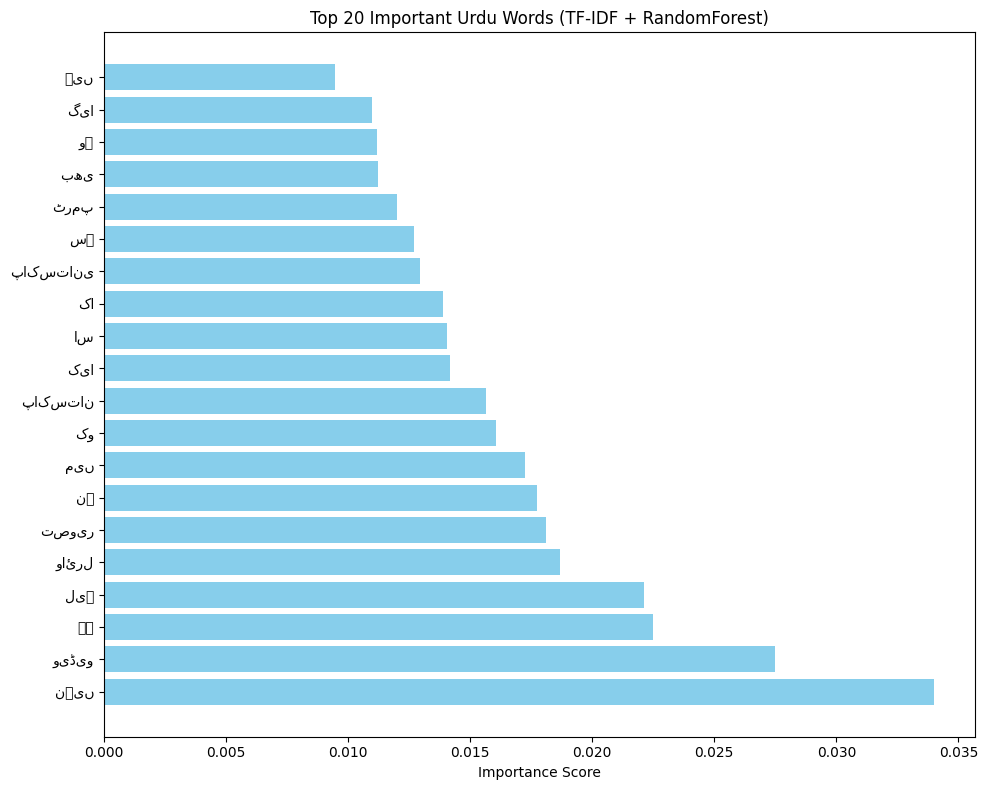

In [50]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled_tf, y_resampled)
importance = rf.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()

#Sort top N important features
top_n = 20
indices = np.argsort(importance)[-top_n:]
top_words = feature_names[indices]
top_importances = importance[indices]


plt.figure(figsize=(10, 8))
plt.barh(top_words, top_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.title("Top 20 Important Urdu Words (TF-IDF + RandomForest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Using RandomForestClassifier to get feature importance word2vec**


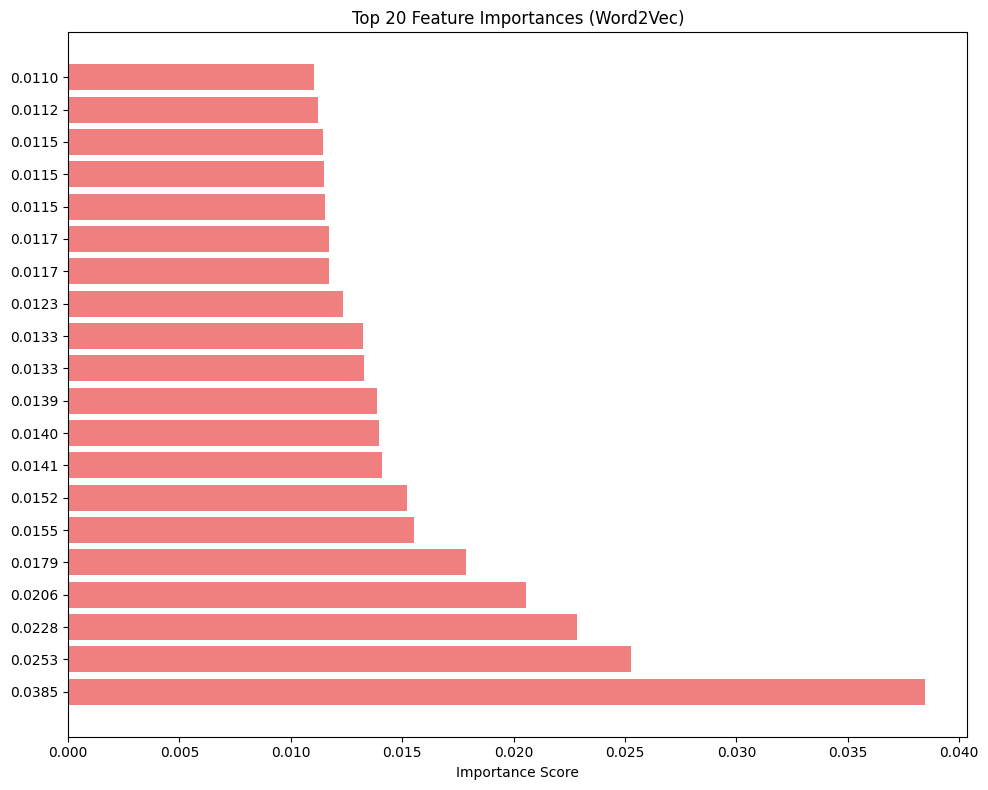

In [51]:
clf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
clf_w2v.fit(X_resampled_w2v, y_resampled)
importances_w2v = clf_w2v.feature_importances_

#plot top 20 important features (vector values)
top_n = 20
indices = np.argsort(importances_w2v)[-top_n:]
top_importances = importances_w2v[indices]
feature_labels = [f"{val:.4f}" for val in top_importances]  # Label by values

#Since produce numerical vectors, the features don’t map to actual words
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_importances, color='lightcoral')
plt.yticks(range(top_n), feature_labels)
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances (Word2Vec)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Using RandomForestClassifier to get feature importance Bert**


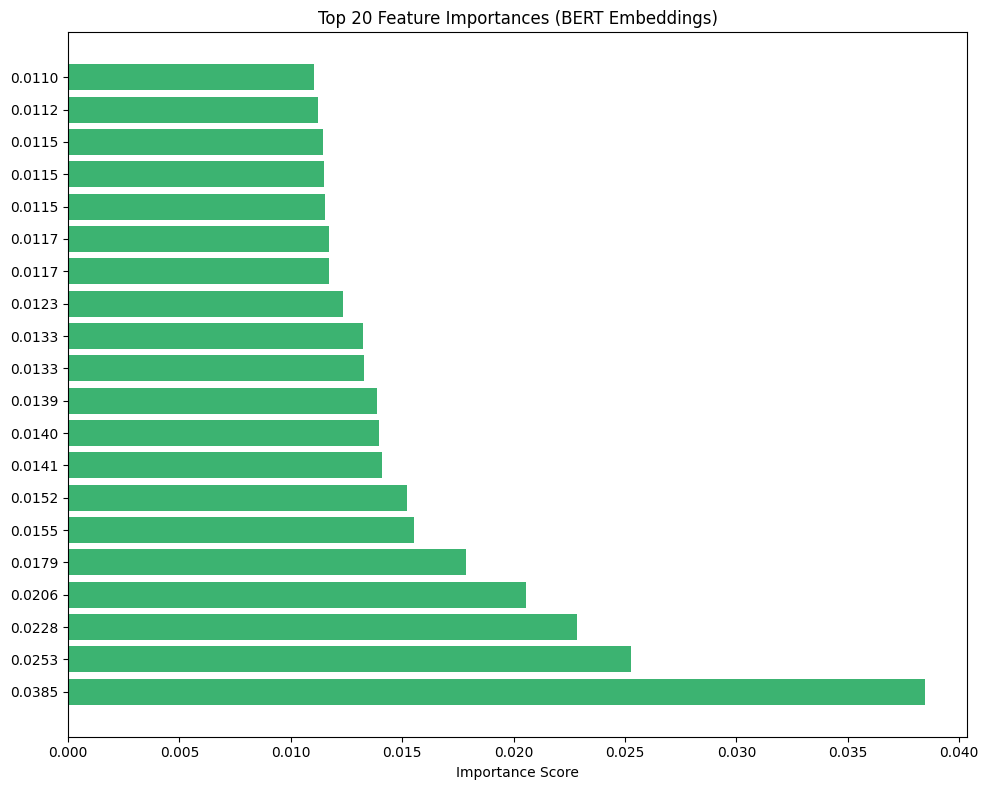

In [52]:
clf_bert = RandomForestClassifier(n_estimators=100, random_state=42)
clf_bert.fit(X_resampled_w2v, y_resampled)
importances_bert = clf_bert.feature_importances_

top_n = 20
indices = np.argsort(importances_bert)[-top_n:]
top_importances = importances_bert[indices]
feature_labels = [f"{val:.4f}" for val in top_importances]
#Since produce numerical vectors, the features don’t map to actual words
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_importances, color='mediumseagreen')
plt.yticks(range(top_n), feature_labels)
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances (BERT Embeddings)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The DataFrame includes:

The original and cleaned text.

Corresponding lengths that reflect the cleaning.

TF-IDF features represented as new columns.

# **Model Implementation & Evaluation**


In [53]:
from sklearn.preprocessing import StandardScaler

# Utility to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["FAKE", "TRUE"], yticklabels=["FAKE", "TRUE"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Split data
print("\n--- Splitting Data ---")

# TF-IDF
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    X_resampled_tf, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Word2Vec
scaler_w2v = StandardScaler()
X_w2v_scaled = scaler_w2v.fit_transform(X_resampled_w2v)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# BERT
if X_resampled_bert is not None:
    scaler_bert = StandardScaler()
    X_bert_scaled = scaler_bert.fit_transform(X_resampled_bert)
    X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
        X_bert_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )
else:
    X_train_bert, X_test_bert, y_train_bert, y_test_bert = None, None, None, None


--- Splitting Data ---


# **MACHINE LEARNING MODELS**

In [54]:
results = {}



# **USING TF-IDF**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_tf, y_resampled, test_size=0.2, random_state=42)


In [56]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred)
}

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       929
           1       0.84      0.88      0.86       926

    accuracy                           0.85      1855
   macro avg       0.85      0.85      0.85      1855
weighted avg       0.85      0.85      0.85      1855



# **USING Word2VEC**

In [57]:

def logistic_regression_w2v():
    print("\n--- Logistic Regression (Word2Vec) ---")
    model = LogisticRegression(random_state=42, max_iter=5000)
    model.fit(X_train_w2v, y_train_w2v)
    y_pred = model.predict(X_test_w2v)
    print(f"Accuracy: {accuracy_score(y_test_w2v, y_pred):.4f}")
    print(classification_report(y_test_w2v, y_pred, target_names=["FAKE", "TRUE"]))
    plot_confusion_matrix(y_test_w2v, y_pred, title="Logistic Regression (W2V)")
    acc = accuracy_score(y_test_w2v, y_pred)
    f1 = f1_score(y_test_w2v, y_pred)
    results['Logistic Regression (W2V)'] = {'Accuracy': acc, 'F1-Score': f1}





--- Logistic Regression (Word2Vec) ---
Accuracy: 0.7482
              precision    recall  f1-score   support

        FAKE       0.76      0.73      0.74       928
        TRUE       0.74      0.76      0.75       927

    accuracy                           0.75      1855
   macro avg       0.75      0.75      0.75      1855
weighted avg       0.75      0.75      0.75      1855



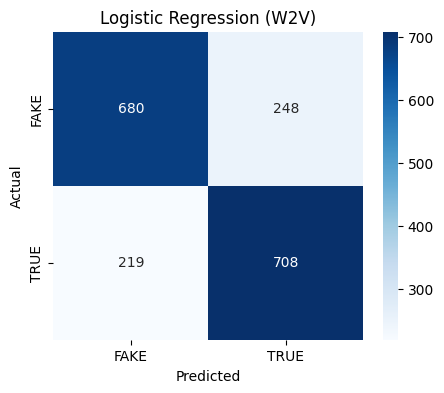

In [58]:
logistic_regression_w2v()

# **USING BERT**

In [59]:
def svm_bert():
    print("\n--- SVM (BERT) ---")
    model = SVC(random_state=42)
    model.fit(X_train_bert, y_train_bert)
    y_pred = model.predict(X_test_bert)
    
    
    acc = accuracy_score(y_test_bert, y_pred)
    f1 = f1_score(y_test_bert, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_bert, y_pred, target_names=["FAKE", "TRUE"]))
    plot_confusion_matrix(y_test_bert, y_pred, title="SVM (BERT)")
    
   
    results['SVM (BERT)'] = {'Accuracy': acc, 'F1-Score': f1}

In [60]:
svm_bert()


--- SVM (BERT) ---


NameError: name 'SVC' is not defined

# **DEEP LEARNING MODELS**

# **USING TF-IDF**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score, classification_report

def deep_learning_tf_idf():
    print("\n--- Deep Learning (TF-IDF) ---")
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_tf.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_tf, y_train_tf, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
    
    y_pred_prob = model.predict(X_test_tf)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    acc = accuracy_score(y_test_tf, y_pred)
    f1 = f1_score(y_test_tf, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_tf, y_pred, target_names=["FAKE", "TRUE"]))
    plot_confusion_matrix(y_test_tf, y_pred, title="DL (TF-IDF)")
    
    results['Deep Learning (TF-IDF)'] = {'Accuracy': acc, 'F1-Score': f1}



--- Deep Learning (TF-IDF) ---
Epoch 1/10


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5917 - loss: 0.6654 - val_accuracy: 0.7817 - val_loss: 0.4649
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7819 - loss: 0.4634 - val_accuracy: 0.8106 - val_loss: 0.4198
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8283 - loss: 0.3792 - val_accuracy: 0.8046 - val_loss: 0.4197
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8513 - loss: 0.3520 - val_accuracy: 0.8133 - val_loss: 0.4072
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8766 - loss: 0.3017 - val_accuracy: 0.8147 - val_loss: 0.4106
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8945 - loss: 0.2726 - val_accuracy: 0.8201 - val_loss: 0.4202
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9086 - loss: 0.2299 - val_accuracy: 0.8194 - val_loss: 0.4196
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9291 - loss: 0.1981 - val_accuracy: 0.8208 - val_

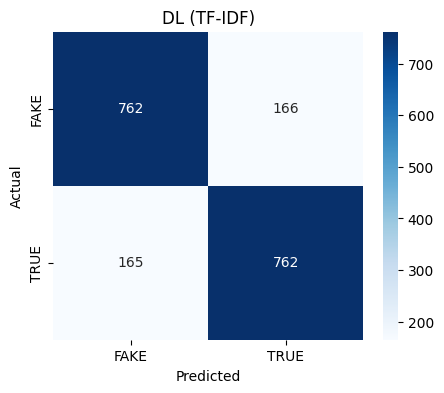

In [ ]:
deep_learning_tf_idf()

# **USING WORD2VEC**

In [ ]:
def deep_learning_w2v_lstm():
    print("\n--- Deep Learning (Word2Vec - LSTM) ---")
    
    X_train_seq = X_train_w2v.reshape((X_train_w2v.shape[0], 1, X_train_w2v.shape[1]))
    X_test_seq = X_test_w2v.reshape((X_test_w2v.shape[0], 1, X_test_w2v.shape[1]))

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(1, X_train_w2v.shape[1])),
        Dropout(0.5),
        LSTM(32),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_seq, y_train_w2v, epochs=15, batch_size=64, validation_split=0.2, verbose=1)
    
    y_pred_prob = model.predict(X_test_seq)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    acc = accuracy_score(y_test_w2v, y_pred)
    f1 = f1_score(y_test_w2v, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_w2v, y_pred, target_names=["FAKE", "TRUE"]))
    plot_confusion_matrix(y_test_w2v, y_pred, title="DL (W2V - LSTM)")
    
    # Save to results
    results['Deep Learning (W2V-LSTM)'] = {'Accuracy': acc, 'F1-Score': f1}



--- Deep Learning (Word2Vec - LSTM) ---
Epoch 1/15


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5921 - loss: 0.6752 - val_accuracy: 0.6833 - val_loss: 0.6047
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6829 - loss: 0.5988 - val_accuracy: 0.7109 - val_loss: 0.5660
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7170 - loss: 0.5590 - val_accuracy: 0.7177 - val_loss: 0.5487
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7209 - loss: 0.5531 - val_accuracy: 0.7271 - val_loss: 0.5356
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7415 - loss: 0.5336 - val_accuracy: 0.7372 - val_loss: 0.5245
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7399 - loss: 0.5221 - val_accuracy: 0.7385 - val_loss: 0.5215
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.5157 - val_accuracy: 0.7473 - val_loss: 0.5114
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7535 - loss: 0.5090 - val_accuracy: 0.7527 - val_loss: 0.5088
Epo

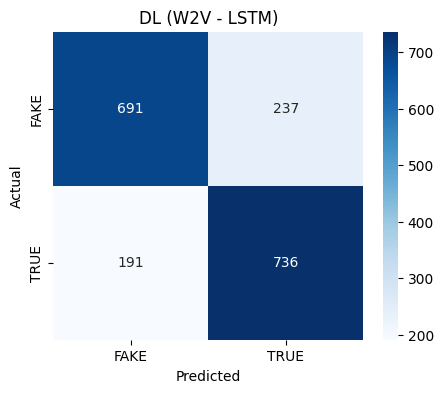

In [ ]:
deep_learning_w2v_lstm()

# **USING BERT**

In [ ]:
def deep_learning_bert():
    if X_train_bert is None:
        print("BERT data not available!")
        return

    print("\n--- Deep Learning (BERT) ---")
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_bert.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_bert, y_train_bert, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
    
    y_pred_prob = model.predict(X_test_bert)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    acc = accuracy_score(y_test_bert, y_pred)
    f1 = f1_score(y_test_bert, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_bert, y_pred, target_names=["FAKE", "TRUE"]))
    plot_confusion_matrix(y_test_bert, y_pred, title="DL (BERT)")
    
    results['Deep Learning (BERT)'] = {'Accuracy': acc, 'F1-Score': f1}



--- Deep Learning (BERT) ---
Epoch 1/10


C:\Users\FAST.LAB12-PC11\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6896 - loss: 0.6611 - val_accuracy: 0.8255 - val_loss: 0.3965
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8234 - loss: 0.4208 - val_accuracy: 0.8363 - val_loss: 0.3866
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8243 - loss: 0.4075 - val_accuracy: 0.8457 - val_loss: 0.3664
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8454 - loss: 0.3588 - val_accuracy: 0.8477 - val_loss: 0.3668
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.3671 - val_accuracy: 0.8464 - val_loss: 0.3586
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8575 - loss: 0.3456 - val_accuracy: 0.8410 - val_loss: 0.3574
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8662 - loss: 0.3229 - val_accuracy: 0.8477 - val_loss: 0.3566
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8781 - loss: 0.2952 - val_accuracy: 0.8518 - val_

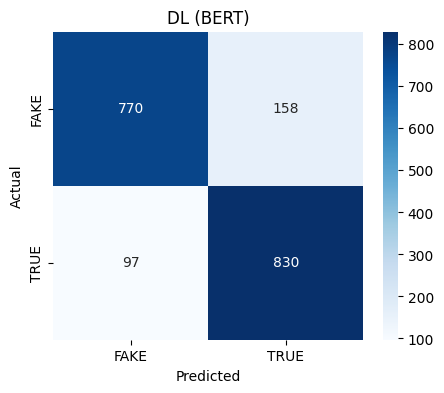

In [ ]:
deep_learning_bert()

# **Performance Metrics & Reporting**



=== Model Comparison Summary ===
Model                          Accuracy   F1-Score  
--------------------------------------------------
Random Forest                  0.5089    0.4919
Logistic Regression (W2V)      0.7569    0.7620
SVM (BERT)                     0.8798    0.8827
Deep Learning (TF-IDF)         0.8216    0.8216
Deep Learning (W2V-LSTM)       0.7693    0.7747
Deep Learning (BERT)           0.8625    0.8668


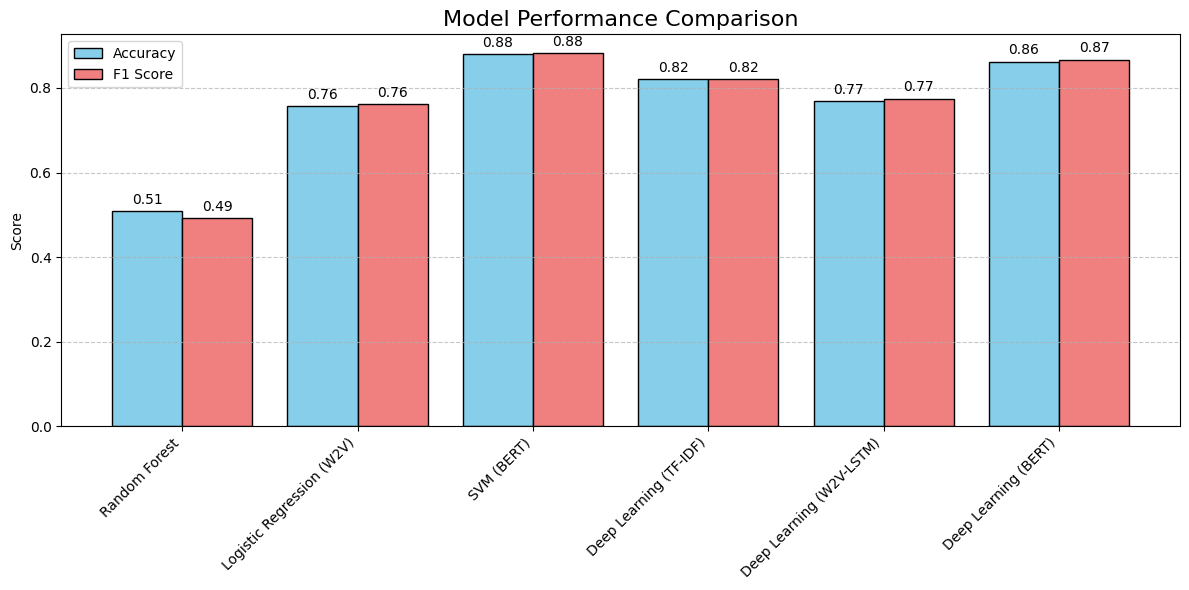

In [ ]:
print("\n\n=== Model Comparison Summary ===")
print("{:<30} {:<10} {:<10}".format('Model', 'Accuracy', 'F1-Score'))
print("-" * 50)
for model_name, scores in results.items():
    print("{:<30} {:.4f}    {:.4f}".format(model_name, scores['Accuracy'], scores['F1-Score']))


models = list(results.keys())
accuracy_scores = [results[m]['Accuracy'] for m in models]
f1_scores = [results[m]['F1-Score'] for m in models]

x = range(len(models))


plt.figure(figsize=(12,6))


plt.bar(x, accuracy_scores, width=0.4, label='Accuracy', align='center', color='skyblue', edgecolor='black')


plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1 Score', align='center', color='lightcoral', edgecolor='black')

for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

for i, score in enumerate(f1_scores):
    plt.text(i + 0.4, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks([i + 0.2 for i in x], models, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Performance Comparison', fontsize=16)
plt.legend()


plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()
